In [1]:
import os
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import backend
import wandb
from wandb.keras import WandbCallback

In [2]:
from encoders import EncoderResNet18, encoderCNN
from decoders import DecoderResNet18, decoderCNN
from datasets import data_loader
from embedding import embedding
from reconstructions import reconstructions
from generations import Generations
from activations import VisualizeActivations
from src.CVAE import CVAE

backend.clear_session()

In [3]:
# TO DO: this should be passed as arguments
dataset_name = 'histo'
model_name = 'CVAE'
kl_coefficient = 0.00008
encoded_dim = 256
learning_rate = 0.0001 
epoch_count = 1
batch_size = 100
patience = 5

In [4]:
if dataset_name == 'experimental':
    #TO DO: move datasets in the repo and change root_folder

    train_ds, val_ds, input_shape, category_count, labels = data_loader(name=dataset_name, root_folder='/home/PERSONALE/nicolas.derus2/HistoDL/datasets/')
else:
    #TO DO: move datasets in the repo and change root_folder

    train_x, test_x, val_x, train_y, test_y, val_y, train_y_one_hot, test_y_one_hot, val_y_one_hot, input_shape, category_count, labels = data_loader(name=dataset_name,
                                                                                                                                        root_folder='/home/PERSONALE/nicolas.derus2/HistoDL/datasets/')

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [5]:

wandb.init(project="HistoDL", entity="nrderus",
  config = {
  "dataset": dataset_name,
  "model": model_name,
  "encoded_dim": encoded_dim,
  "kl_coefficient": kl_coefficient,
  "learning_rate": learning_rate,
  "epochs": epoch_count,
  "batch_size": batch_size,
  "patience": patience,
})

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nrderus. Use `wandb login --relogin` to force relogin


In [6]:
if 'resnet' in model_name:
    encoder = EncoderResNet18(encoded_dim = encoded_dim)
    encoder = encoder.model(input_shape=(input_shape[0], input_shape[1], input_shape[2] + category_count))
else:
    encoder = encoderCNN(input_shape, category_count, encoded_dim)

encoder

2022-07-13 00:14:25.752443: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
if 'resnet' in model_name:
    decoder = DecoderResNet18( encoded_dim = encoded_dim)
    decoder = decoder.model(input_shape=(encoded_dim + category_count,))
else:
    decoder = decoderCNN(input_shape, category_count, encoded_dim)

decoder

In [8]:
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
    # This is the TPU initialization code that has to be at the beginning.
    tf.tpu.experimental.initialize_tpu_system(resolver)
    print("All devices: ", tf.config.list_logical_devices('TPU'))

    strategy = tf.distribute.experimental.TPUStrategy(resolver)
    with strategy.scope():
        cvae = CVAE(encoder, decoder, kl_coefficient, input_shape, category_count)
        cvae.built = True
        cvae_input = cvae.encoder.input[0]
        cvae_output = cvae.decoder.output
        mu = cvae.encoder.get_layer('mu').output
        log_var = cvae.encoder.get_layer('log_var').output

        opt = keras.optimizers.Adam(learning_rate = learning_rate)
        cvae.compile(optimizer = opt, run_eagerly=False)
except:
    cvae = CVAE(encoder, decoder, kl_coefficient, input_shape, category_count)
    cvae.built = True
    cvae_input = cvae.encoder.input[0]
    cvae_output = cvae.decoder.output
    mu = cvae.encoder.get_layer('mu').output
    log_var = cvae.encoder.get_layer('log_var').output


    opt = keras.optimizers.Adam(learning_rate = learning_rate)
    cvae.compile(optimizer = opt, run_eagerly=False)

In [9]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
             patience=patience, restore_best_weights=False)

history = cvae.fit([train_x, train_y_one_hot],
                   validation_data = ([val_x, val_y_one_hot],None),
                   epochs = epoch_count,
                   batch_size = batch_size,
                   callbacks=[early_stop, WandbCallback(save_model = False) ]) #save_weights_only -> ValueError: Unable to create dataset (name already exists)

wandb: WARNING Unable to compute FLOPs for this model.


600/600 [==============================] - 490s 814ms/step - loss: 772.9642 - reconstruction_loss: 46.6958 - kl_loss: 726.2684 - loss_no_weights: 9078401.0000 - val_loss: 95.6320 - val_reconstruction_loss: 94.8095 - val_kl_loss: 0.8225 - val_loss_no_weights: 10376.5820 - _timestamp: 1657664558.0000 - _runtime: 498.0000


In [10]:
_, input_label_train, train_input = cvae.conditional_input([train_x, train_y_one_hot])
_, input_label_test, test_input = cvae.conditional_input([test_x, test_y_one_hot])
_, input_label_val, val_input = cvae.conditional_input([val_x, val_y_one_hot])

train_x_mean, train_log_var = cvae.encoder.predict(train_input)
test_x_mean, test_log_var = cvae.encoder.predict(test_input)
val_x_mean, val_log_var = cvae.encoder.predict(val_input)

/home/PERSONALE/nicolas.derus2/miniconda3/envs/H-VAE/lib/python3.9/site-packages/matplotlib/collections.py:1098: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


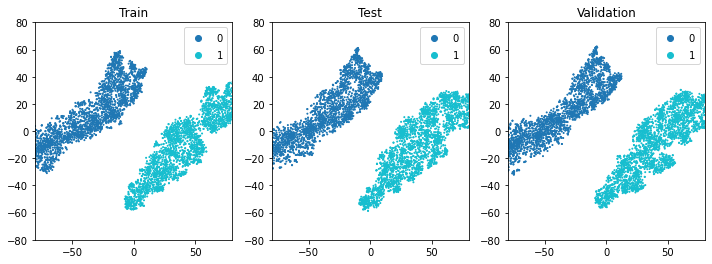

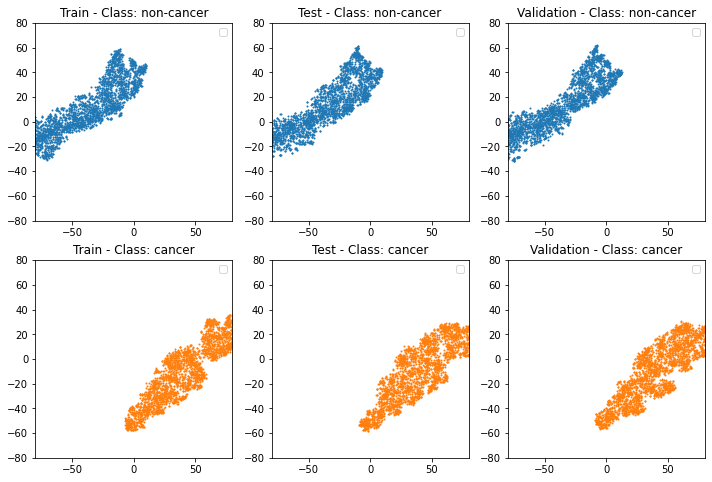

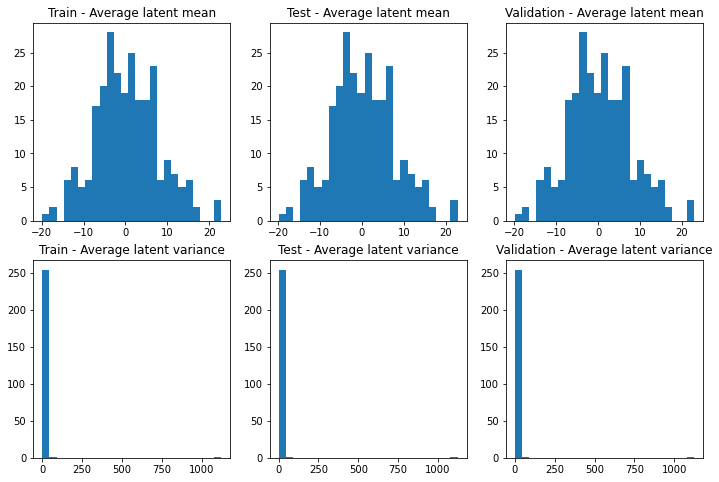

In [11]:
embedding(encoded_dim, category_count, train_x_mean, test_x_mean, val_x_mean, train_y, test_y, val_y, train_log_var, test_log_var, val_log_var, labels, xy_lim = 80, quantity = 5000, avg_latent=True)

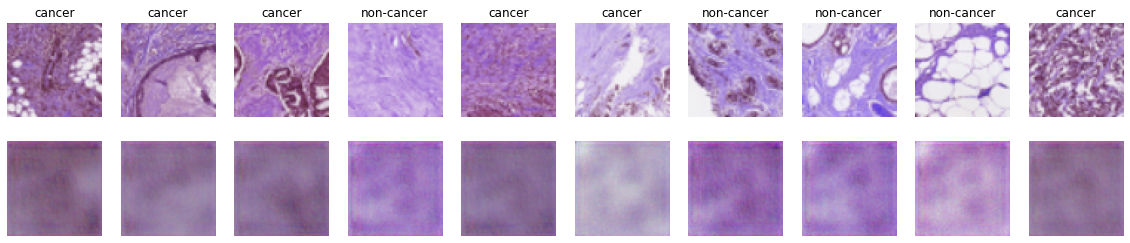

In [12]:
reconstructions(cvae, train_x, train_y, train_x_mean, train_log_var, input_label_train, labels)

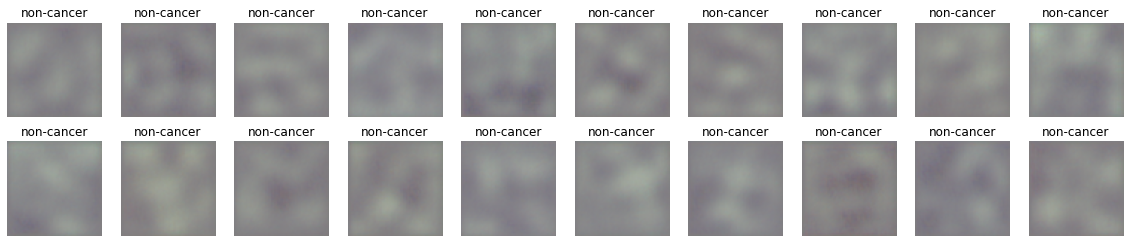

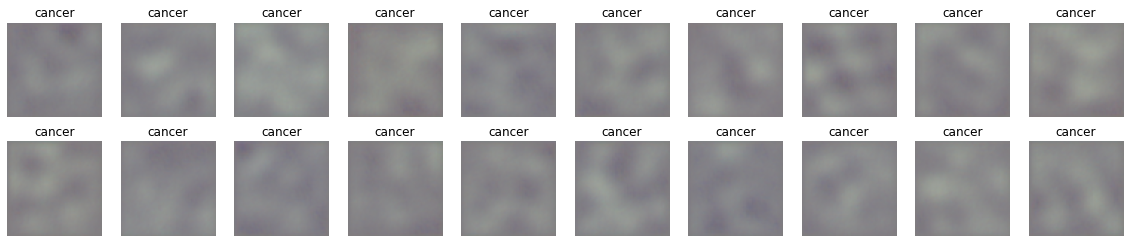

In [13]:
generator = Generations(cvae, encoded_dim, category_count, input_shape, labels)
generator()

In [14]:
wandb.finish(exit_code=0, quiet = True) 

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 258), dtype=tf.float32, name='decoder_input'), name='decoder_input', description="created by layer 'decoder_input'") at layer "dense_3". The following previous layers were accessed without issue: []

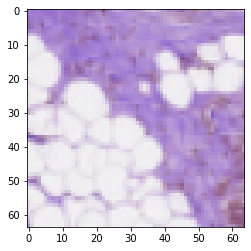

In [17]:

activations = VisualizeActivations(cvae, test_x, test_y_one_hot)
activations()

In [22]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import models
import numpy as np
import math
import wandb

class VisualizeActivations():
    def __init__(self, model, test_x, test_y_one_hot):
        self.model = model
        self.test_x = test_x
        self.test_y_one_hot = test_y_one_hot

    def visualize_activations(self, model):
        test = self.test_x[0]
        plt.imshow(test)
        test = np.expand_dims(test, axis=0)
        test.shape
        test_label = self.test_y_one_hot[0]
        img_tensor = [test, test_label]

        # Extracts the outputs of the top 8 layers:
        layer_outputs = []
        layer_names = []
        
        for layer in self.model.layers[1:]:
            
            try: 
                layer_outputs.append(layer.get_output_at(0)) #N: this depends on the architecture, resnet = , CNN =
                layer_names.append(layer.name)
            
            except:
                layer_outputs.append(layer.output)
                layer_names.append(layer.name)

        # Creates a model that will return these outputs, given the model input:
        activation_model = models.Model(inputs= model.input, outputs=layer_outputs)
        
        # This will return a list of 5 Numpy arrays:
        # one array per layer activation
        if 'encoder' in model.name:
            _, input_label, conditional_input = model.conditional_input(img_tensor)
            activations = activation_model.predict(conditional_input) #for encoder

        if 'decoder' in model.name:
            _, input_label, conditional_input = model.conditional_input(img_tensor)
            input_label = np.expand_dims(input_label, axis=0)
            z_mean, z_log_var = model.encoder(conditional_input)
            z_cond = model.sampling(z_mean, z_log_var, input_label)
            
            activations = activation_model.predict(z_cond) #for decoder
        
        for activation, name in zip(activations[0:], layer_names[0:]):
            print(name)
            print(activation.shape)
        
        for _, (activation, name) in enumerate(zip(activations[0:], layer_names[0:])):
            print(name)
            self.plot_filters(activation, name, model_name=model.name)

    def plot_filters(activation_layer, layer_name, model_name):

        if len(activation_layer.shape) == 2: # if flat layer
            print('flat')
            return None
        n = math.floor(np.sqrt(activation_layer.shape[3]))

        if int(n + 0.5) ** 2 == activation_layer.shape[3]:
            m = n
        else:
            m = math.floor(activation_layer.shape[3] / n)

        if activation_layer.shape[3] == 1:
            fig, ax = plt.subplots(1, 1, sharex='col', sharey='row',
                                    figsize=(15, 15))
            fig.suptitle(layer_name)

            ax.imshow(activation_layer[0,:, :, 0], cmap='viridis')
            wandb.log({"Activations": wandb.Image(plt, caption="{}_{}".format(model_name, layer_name)) })
    
            return None   

        if n == 1:
            fig, ax = plt.subplots(1, 3, sharex='col', sharey='row',figsize=(15, 15))
            fig.suptitle(layer_name)
            for i in range(3):
                ax[i].imshow(activation_layer[0,:, :, i], cmap='viridis')
            wandb.log({"Activations": wandb.Image(plt, caption="{}_{}".format(model_name, layer_name)) })
            return None   

        fig, ax = plt.subplots(n, m, sharex='col', sharey='row',figsize=(15, 15))
        fig.suptitle(layer_name)

        filter_counter = 0
        for i in range(n):
            for j in range(m):
                ax[i, j].imshow(activation_layer[0,:, :, filter_counter], cmap='viridis')
                filter_counter += 1
                if filter_counter == (activation_layer.shape[3] ):
                    break

        wandb.log({"Activations": wandb.Image(plt, caption="{}_{}".format(model_name, layer_name)) })
        return None

    def __call__(self):
        self.visualize_activations(self.model.encoder)
        self.visualize_activations(self.model.decoder)

block1_conv1
(1, 64, 64, 16)
block1_conv2
(1, 64, 64, 16)
batch_normalization
(1, 64, 64, 16)
leaky_re_lu
(1, 64, 64, 16)
block2_conv1
(1, 64, 64, 32)
block2_conv2
(1, 64, 64, 32)
batch_normalization_1
(1, 64, 64, 32)
leaky_re_lu_1
(1, 64, 64, 32)
S4
(1, 32, 32, 32)
block3_conv1
(1, 32, 32, 64)
block3_conv2
(1, 32, 32, 64)
batch_normalization_2
(1, 32, 32, 64)
leaky_re_lu_2
(1, 32, 32, 64)
flatten
(1, 65536)
dense
(1, 512)
mu
(1, 256)
log_var
(1, 256)
block1_conv1
encoder


Error: You must call wandb.init() before wandb.log()

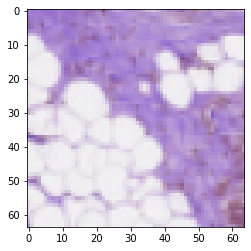

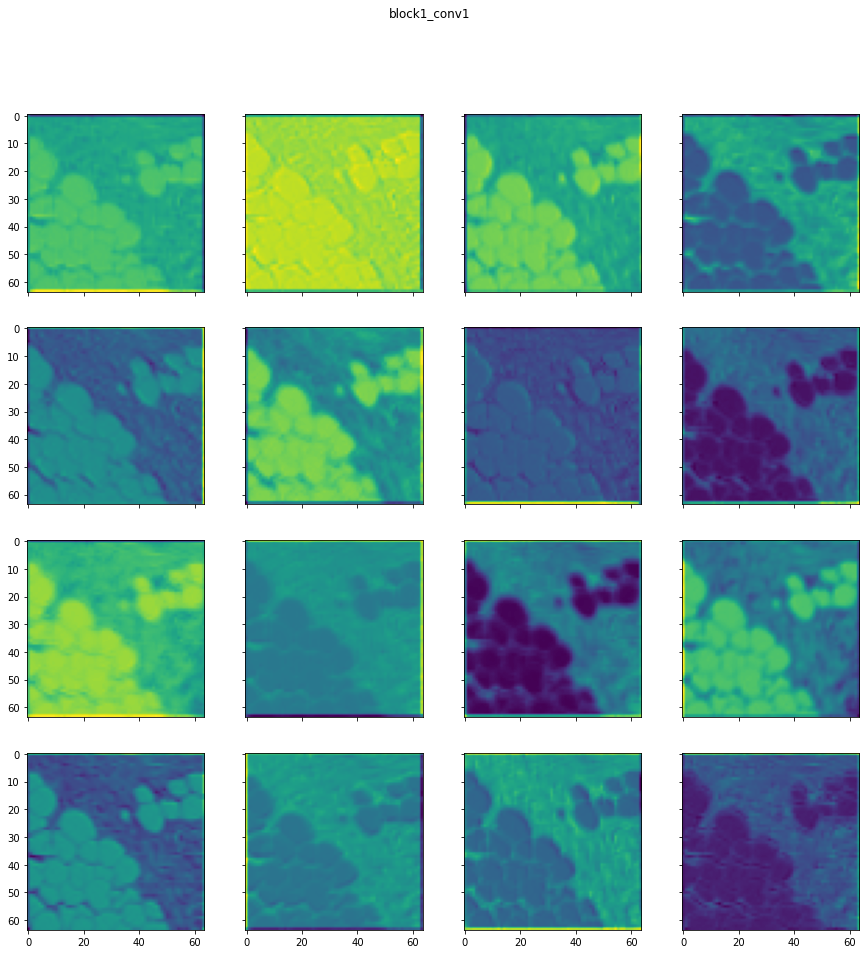

In [64]:
activations = VisualizeActivations(cvae, cvae.encoder, cvae.decoder, test_x, test_y_one_hot)
activations()